# <center> <u> ANALYSIS - SURROGATE MODEL FOR WOVEN COMPOSITES BEHAVIOR

## Purpose
The aim of the notebook is to analyse the properties of different composites using machine learning. The analysis is done by using inputs in terms of parameters representing different fibres or composites that define our initial composite structure.

## WIP - improvements

# Library import


In [2]:
#import modin.pandas as pd
import numpy as np
import math
import csv
import os
import sys
import pandas as pd
from numpy import random
from numpy.linalg import cholesky as chol
import matgrab
from scipy.io import loadmat
from scipy.stats import norm, uniform, beta, multivariate_normal, stats

#Libraries needed for Gaussian regression

from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct, WhiteKernel, Matern, RationalQuadratic

# Options for pandas
pd.options.display.max_columns = 10
pd.options.display.max_rows = 20

# Visualizations
from tabulate import tabulate
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib widget
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")

import seaborn as sns
sns.set()
sns.set_context("talk")

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

## Help Functions

In [3]:
#Check current path
print(os.getcwd())

/Users/Ian_1/Desktop/MASTER THESIS WORK/Documents


In [4]:
#Unpack our data by stacking different lists vertically
def stack(data):
    for i in data:
        for j in i:
            x_test_stack = np.vstack(j)
    return(x_test_stack)

#Prepare data for GPy
def gpyarrange(data):
    for i in data:
        i.reshape((-1,1))
    return(data)

#Check for structure of data
def get_structure(data):
    print('The data is of shape', data.shape, 'and of dimension', data.ndim)
    
def MSE_analysis(array1, array2):
    """
    Takes two arrays and comparatively calculates the MSE for each corresponding entry.
    """
    assert array1.shape == array2.shape, "The two arrays should be of the same dimension"
    y_pred_error = np.zeros((array1.shape[0], array2.shape[1]))
    for i in range(array1.shape[0]):
        for j in range(array2.shape[1]):
            y_pred_error[i][j] = np.square(np.subtract(array1[i][j],array2[i][j])).mean()
    return (y_pred_error, pd.DataFrame(y_pred_error) )

def RMSE_analysis(array1, array2):
    """
    Takes two arrays and comparatively calculates the MSE for each corresponding entry.
    """
    assert array1.shape == array2.shape, "The two arrays should be of the same dimension"
    y_pred_error = np.zeros((array1.shape[0], array2.shape[1]))
    for i in range(array1.shape[0]):
        for j in range(array2.shape[1]):
            y_pred_error[i][j] = math.sqrt( np.square(np.subtract(array1[i][j],array2[i][j])).mean() )
    return (y_pred_error, pd.DataFrame(y_pred_error) )

def data_split(df):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    return(train_df,val_df,test_df)

In [5]:
#Print dataframe
def dataframe_to_latex(dataframe):
    print(( dataframe.head(5) ).to_latex(index=False, formatters={"name": str.upper},float_format="{:.1f}".format,))  

# Gaussian process for time-independent sequential data

## Gaussian process

**Gaussian processes (GPs)** allow one to model and make predictions about data using GPs. Here's a general outline of how to perform Gaussian processes:

1. **Data Preparation:** Start by collecting or preparing the data with the corresponding observations.

2. **Define the Kernel:** The kernel function, also known as the covariance function or the similarity function, is a crucial component of a Gaussian process. It determines the assumptions made about the underlying process. For time-dependent data, we need to choose a kernel that captures temporal dependencies. Some commonly used kernels for time series data include the squared exponential (also known as the radial basis function or RBF) and the periodic kernel.

3. **Model Training:** Fit the Gaussian process model to the data. This involves estimating the hyperparameters of the kernel, such as length scales and noise levels. The most common approach is to maximize the log marginal likelihood, which measures how well the model fits the training data. Optimization methods like gradient-based algorithms or numerical optimization techniques can be used to find the optimal hyperparameters.

4. **Predictions:** After training the GP model, use it to make predictions on unseen data points. Given a new input (time stamp), the GP model provides a predictive distribution over possible output values. The predictive distribution is typically a Gaussian distribution characterized by its mean and covariance.

5. **Updating the Model:** As new observations become available over time, one can update your Gaussian process model to incorporate the new data. This process is known as online learning or incremental learning. By sequentially updating the model with new data, one can continuously refine the predictions and adapt to changing patterns in the time-dependent process.

In a nutshell, GP regression simply amounts to generating a prediction given some training data through conditioning, under the assumption that the underlying function is a infinite-dimensional vector that follows some Gaussian distribution with a kernel acting as its prior.


## Data import
We retrieve all the required data for the analysis.

In [22]:
path = "/Volumes/NO NAME/MASTER THESIS WORK/Documents/Results"
meanfield = loadmat("/Volumes/NO NAME/MASTER THESIS WORK/Data/WovenMeanField.mat")
meanfield_glob_scaled = loadmat("/Volumes/NO NAME/MASTER THESIS WORK/Data/WovenMeanField_GloballyScaled_0_1_fixedFeatures.mat")
timeindepdata = '/Volumes/NO NAME/MASTER THESIS WORK/Data/features_final_version.xlsx'

In [23]:
class data_analysis():
    def __init__(self, file_path, sheet_name):
        self.file_path = file_path
        self.sheet_name = sheet_name
        
    def extract_data(self):
        """
        Takes in the sheet name in a given excel file.
        Returns a tuple of 4 items in the following order:
        1. A Pandas dataframe of the sheet
        2. A list of the columns from the sheet in string format
        3. A list of the input features from the sheet in string format
        4. A list of the output features from the sheet in string format
        """
        df = pd.read_excel(self.file_path, self.sheet_name)
        columns = ['phiF','EM','nuM','EF','nuF','E11','E22', 'E33','nu12','nu13','nu23','G12','G13','G23']
        input_features = ['phiF','EM','nuM','EF','nuF']
        targets = ['E11','E22','E33','nu12','nu13','nu23','G12','G13','G23']
        df = df[columns]
        return(df, columns, input_features, targets)
    
    def data_split(self,test_data_fraction):
        """
        Takes in a dataframe and a percentage value for which the test data is supposed to be a fraction of the dataset.
        """
        dataframe, columns, input_features, targets = self.extract_data()
        frac = test_data_fraction
        test_data = dataframe.sample(frac = frac)
        training_data = dataframe.drop(test_data.index)
        return(training_data, test_data)

### Evaluate dataset

#### Plot sample input feature

In [24]:
data_analysis = data_analysis(timeindepdata,'InputForKeras')
dataframe, columns, input_features, targets = extract_data = data_analysis.extract_data()
df = dataframe
df

,phiF,EM,nuM,EF,nuF,...,nu13,nu23,G12,G13,G23
0,0.450000,6750.000000,0.370000,427550.000000,0.300000,...,0.334033,0.470433,7214.333,6945.667,7341.000
1,0.525000,8375.000000,0.310000,606825.000000,0.250000,...,0.272510,0.372067,12258.000,11407.670,11501.670
2,0.375000,5125.000000,0.430000,248275.000000,0.350000,...,0.395900,0.600233,4067.667,4173.000,4648.667
3,0.562500,5937.500000,0.340000,517187.500000,0.225000,...,0.262243,0.358133,9092.333,9351.000,9260.333
4,0.412500,9187.500000,0.460000,158637.500000,0.325000,...,0.404333,0.614533,7516.667,7277.333,8925.000
...,...,...,...,...,...,...,...,...,...,...,...
395,0.546680,5594.726562,0.274844,512985.742188,0.232422,...,0.246130,0.309010,8954.333,8817.667,8115.000
396,0.396680,8844.726562,0.394844,154435.742188,0.332422,...,0.367000,0.487067,7465.000,7178.000,7396.000
397,0.321680,7219.726562,0.334844,333710.742188,0.282422,...,0.314077,0.426367,5717.333,5496.667,5199.000
398,0.471680,3969.726562,0.454844,692260.742188,0.382422,...,0.417967,0.656067,4362.000,4442.667,6362.667


In [25]:
#dataframe_to_latex(df[input_features])
#dataframe_to_latex(df[targets])

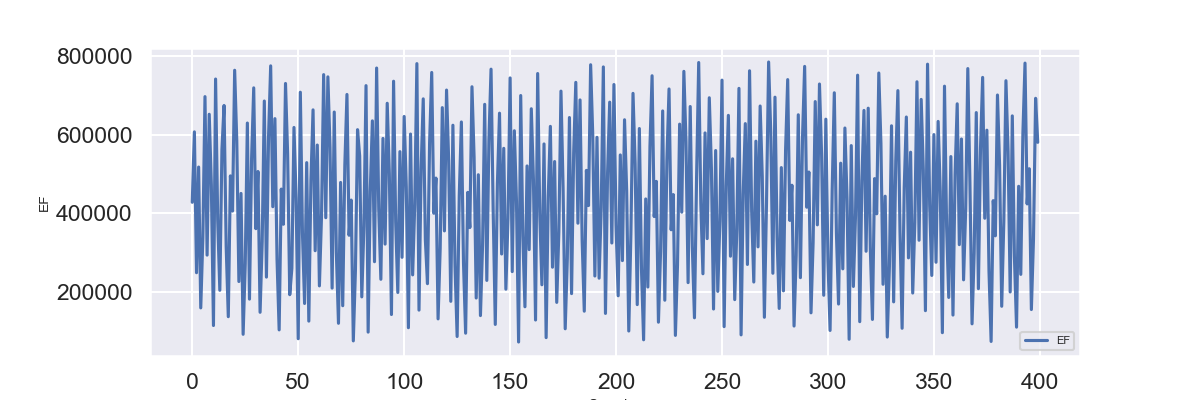

In [26]:
plt.figure(figsize=(12,4))
plt.plot(range(len(df)),df['EF'], label = "EF")
plt.xlabel('Samples', fontsize=10)
plt.ylabel('EF', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

### A note on kernels

Increasing the lengthscale parameter l increases the spread of the covariance. Increasing the amplitude parameter sigma increases the maximum value of the covariance.

### TRAINING OUR MODEL

In [37]:
def model_training(dataframe, test_data_fraction):
    """
    Takes in a dataframe and a percentage value for which the test data is supposed to be a fraction of the dataset.
    Returns:
    1.test_ypred
    2.ytest
    3.scaled_ytest
    4.test_RMSE_array
    5.unscaled_test_rmse_arr
    6.unscaled_test_std_arr
    7.err_col
    8.scaler
    """
    
    f = open(f"{path}" + "/" + "InputForKeras_training_data.txt","w+")
    
    training_data, test_data = data_analysis.data_split(test_data_fraction)
    
    training_points = []
    err_col = [(u'\u00B1'+ x) for x in targets]
    test_RMSE_array = np.array([])
    validation_RMSE_array = np.array([])
    
    model_rmse_arr = np.zeros( len(err_col) )
    model_std_arr = np.zeros( len(err_col) )
    test_rmse_arr = np.zeros( len(err_col) )
    test_std_arr = np.zeros( len(err_col) )
    
    for i in [ x for x in range(50,96,1) ]:
        """Sample the training dataset"""
        training_set = training_data.sample(frac = i*0.01) #Sample them randomly
        
        """Extract the features and outputs"""
        test_set = test_data
        
        xtrain = training_set[input_features]
        ytrain = training_set[targets]
        xtest = test_set[input_features]
        ytest = test_set[targets]
        
        """Define scaler"""
        x_scaler = preprocessing.MinMaxScaler()
        y_scaler = preprocessing.MinMaxScaler()
        transformer_x = x_scaler.fit(xtrain)
        transformer_y = y_scaler.fit(ytrain)
        
        scaled_xtrain = transformer_x.transform(xtrain)
        scaled_ytrain = transformer_y.transform(ytrain)
        scaled_xtest = transformer_x.transform(xtest)
        scaled_ytest = transformer_y.transform(ytest)
        
        
        """
        We shall implement the RBF kernel.
        """
        kernel = 1.0 * RBF( length_scale=1.0, length_scale_bounds=(1e-02, 1000.0) )
        
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
        gpr.fit(scaled_xtrain, scaled_ytrain)                 
    
        """Test using hidden dataset"""
        test_ypred, test_std_prediction = gpr.predict(scaled_xtest, return_std=True)
        test_data_MSE = mean_squared_error( np.array(scaled_ytest), np.array(test_ypred) )
        test_data_RMSE = math.sqrt(test_data_MSE)
        test_RMSE_array = np.append(test_RMSE_array, test_data_RMSE)
        #training_points = np.append( training_points, len(model_data) - (len(model_data)*i*0.01) - len(model_data)*0.2 )
        
        """Checking errors and standard deviation across the predictions on the individual features"""
        """During testing"""
        test_RMSE = np.zeros( len(err_col) )
        test_STD = np.zeros( len(err_col) )
        for j in range( np.shape(test_ypred)[1] ):
            test_RMSE[j] = math.sqrt( mean_squared_error( np.array(scaled_ytest)[:,j], np.array(test_ypred)[:,j] ) )
            test_STD[j] = np.std( test_ypred[:,j] )
        test_rmse_arr = np.vstack( (test_rmse_arr, test_RMSE) )
        test_std_arr = np.vstack( (test_std_arr, test_STD) )
        
        if i == 95:
            scaler = transformer_y
            unscaled_test_rmse_arr = scaler.inverse_transform(test_rmse_arr)
            unscaled_test_std_arr  = scaler.inverse_transform(test_std_arr)
        ##"""PLOT KERNEL """   
        
        """Print results"""
        print( round(i),"% OF DATASET USED FOR MODELING, 10% USED FOR TESTING,")
        print("Datapoints used for model training:", len(training_set) )
        print("Datapoints used for model testing:", len(test_data) )
        print("Kernel:", gpr.kernel_)
        print("Test MSE:", test_data_MSE)
        print("Test RMSE:", test_data_RMSE) 
        print('----------------------------------------------------------------')
        
        f.write(f"{round(i)} % OF DATASET USED FOR MODELING, 10% USED FOR TESTING \n")
        f.write(f"Datapoints used for model training:, {len(training_set)} \n" )
        f.write(f"Datapoints used for model testing:, {len(test_data)} \n" )
        f.write(f"Kernel: {gpr.kernel_} \n")
        f.write(f"Test MSE: {test_data_MSE} \n")
        f.write(f"Test RMSE: {test_data_RMSE} \n") 
        f.write('---------------------------------------------------------------- \n')
        
    f.close()
    return(training_data, test_data, test_ypred, ytest, scaled_ytest, test_RMSE_array, unscaled_test_rmse_arr, unscaled_test_std_arr, err_col, scaler)

In [38]:
training_data, test_data, test_ypred, ytest, scaled_ytest, test_RMSE_array, unscaled_test_rmse_arr, unscaled_test_std_arr, err_col, scaler = model_training(df, 0.1)

50 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 180
Datapoints used for model testing: 40
Kernel: 0.306**2 * RBF(length_scale=0.554)
Test MSE: 0.0022180424196757047
Test RMSE: 0.047096097711760626
----------------------------------------------------------------
51 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 184
Datapoints used for model testing: 40
Kernel: 0.3**2 * RBF(length_scale=0.497)
Test MSE: 0.0017669134744304031
Test RMSE: 0.04203466990985421
----------------------------------------------------------------
52 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 187
Datapoints used for model testing: 40
Kernel: 0.303**2 * RBF(length_scale=0.513)
Test MSE: 0.0022953181816894683
Test RMSE: 0.04790947903796772
----------------------------------------------------------------
53 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model 

77 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 277
Datapoints used for model testing: 40
Kernel: 0.28**2 * RBF(length_scale=0.459)
Test MSE: 0.0015193758569997534
Test RMSE: 0.03897917209228222
----------------------------------------------------------------
78 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 281
Datapoints used for model testing: 40
Kernel: 0.272**2 * RBF(length_scale=0.459)
Test MSE: 0.0014878192327475942
Test RMSE: 0.038572259886446816
----------------------------------------------------------------
79 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model training: 284
Datapoints used for model testing: 40
Kernel: 0.27**2 * RBF(length_scale=0.448)
Test MSE: 0.0014329222606786767
Test RMSE: 0.03785395964332763
----------------------------------------------------------------
80 % OF DATASET USED FOR MODELING, 10% USED FOR TESTING,
Datapoints used for model 

In [40]:
def evaluation_plot(ytest, test_ypred, scaler, targets, parameters ):
    
    for i in parameters:
        x = pd.DataFrame(ytest, columns = targets)[i]
        y = ( pd.DataFrame(scaler.inverse_transform(test_ypred), columns = targets) )[i]
        plt.figure(figsize=(10,7))
        plt.title(f"Predicted {i} vs Expected {i}")
        #plt.plot( range(len(ytest['E11'])), ytest['E11'], color='C1')
        #plt.plot( range(len(predE11)), predE11, color='C2')
        plt.scatter( y/1000, x/1000, color='C1')
        plt.axline((0, 0), slope=1, color='black')
        plt.xlabel(f"Expected {i}(GPa)",fontsize=10)
        plt.ylabel(f"Predicted {i}(GPa)",fontsize=10)
        plt.savefig(f"{path}" + "/" + f"Predicted_{i}_vs_Expected_{i}_InputForKeras")
        #plt.savefig(f'{Path}' + f'{namestr(file, globals())}'+'_Ts_v_t.png')
    

In [49]:
def model_RMSE(training_data, test_RMSE_array):
    plt.figure(figsize=(10,7))
    plt.title( "Prediction RMSE vs training datapoints")
    plt.plot( [ len(training_data)*0.01*i for i in range(50,96,1) ], test_RMSE_array, label = "RMSE_testing", color='C1')
    plt.xlabel('Sampled training datapoints',fontsize=10)
    plt.ylabel('Prediction RMSE',fontsize=10)
    plt.legend(loc=4,prop={'size': 8})
    #plt.legend(["First data with {}".format(input_var1),"Second data with {}".format(input_var2)])
    plt.savefig(f"{path}" + "/" + 'RMSE_testing_400_MinMaxScaler.png',bbox_inches='tight')
    plt.show()

In [42]:
parameters = ['E11','E33','nu12','nu23','G12','G23']

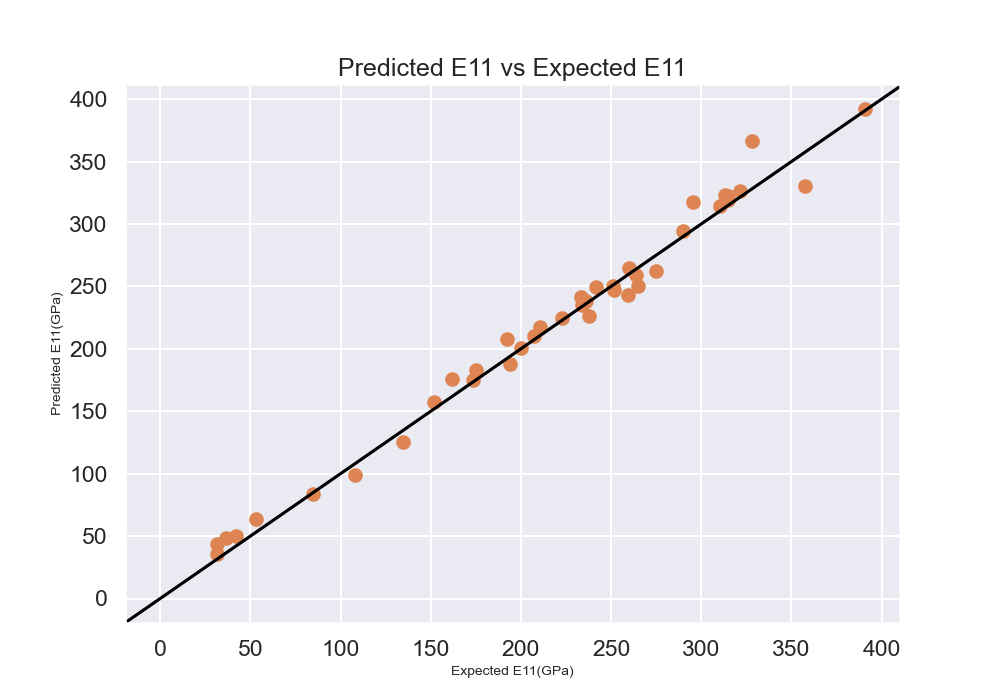

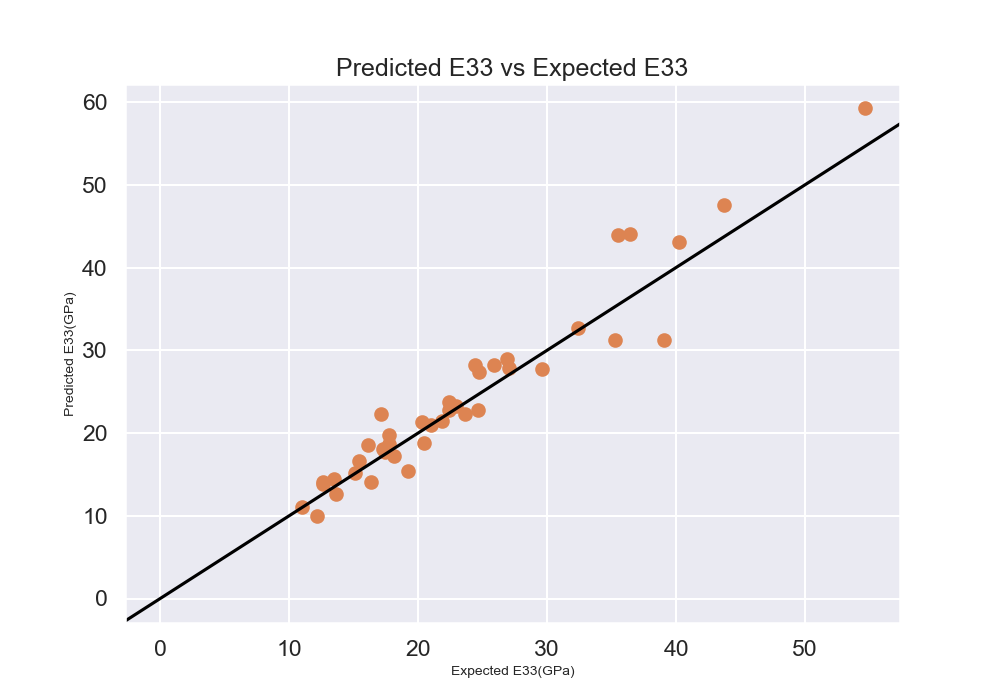

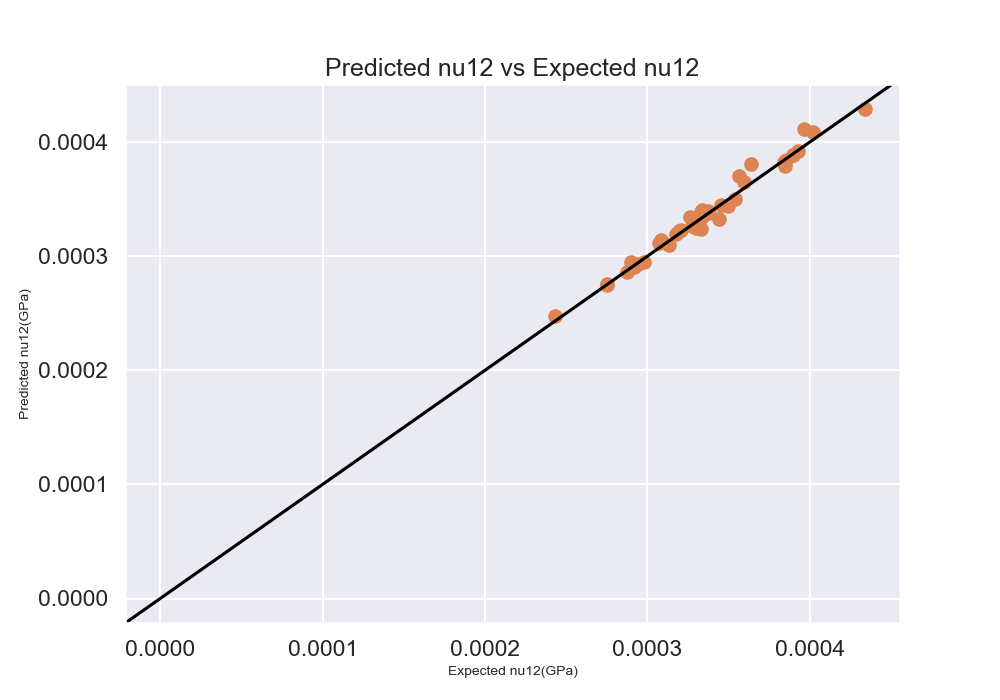

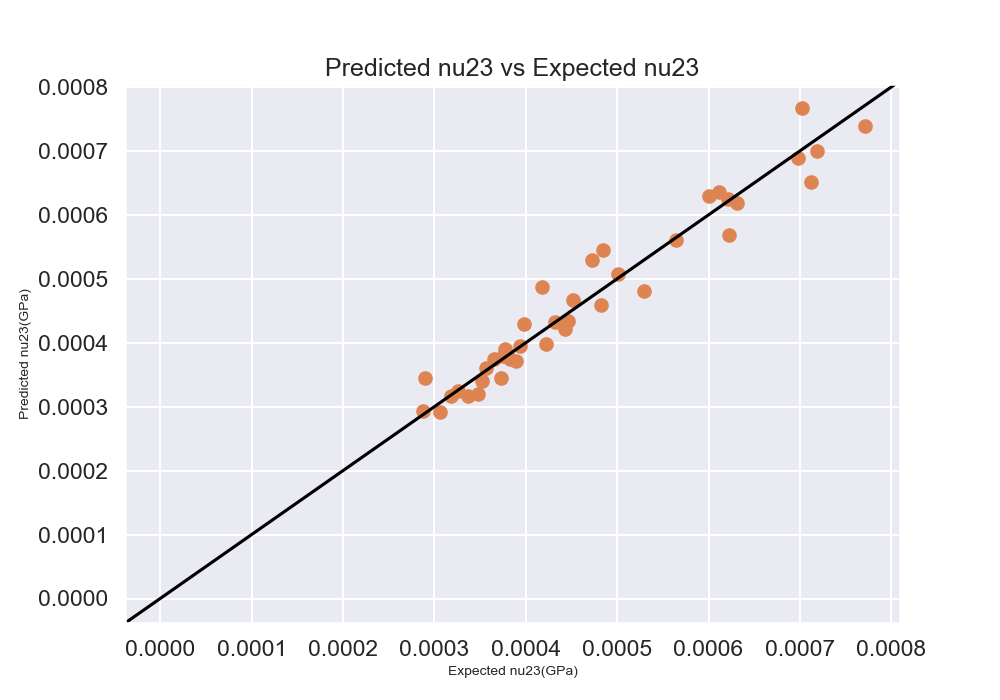

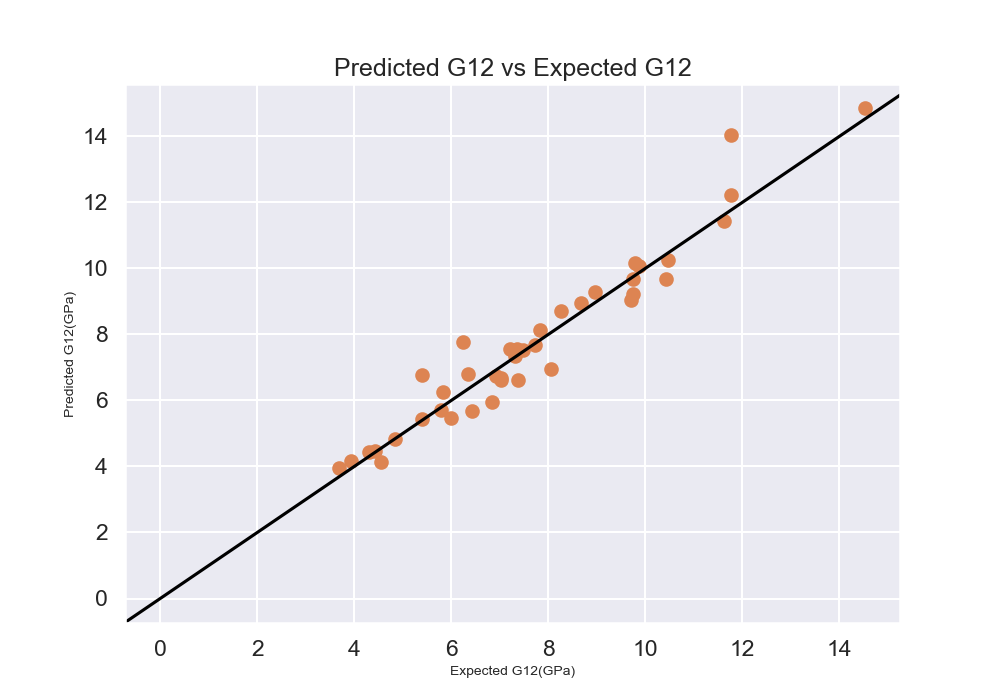

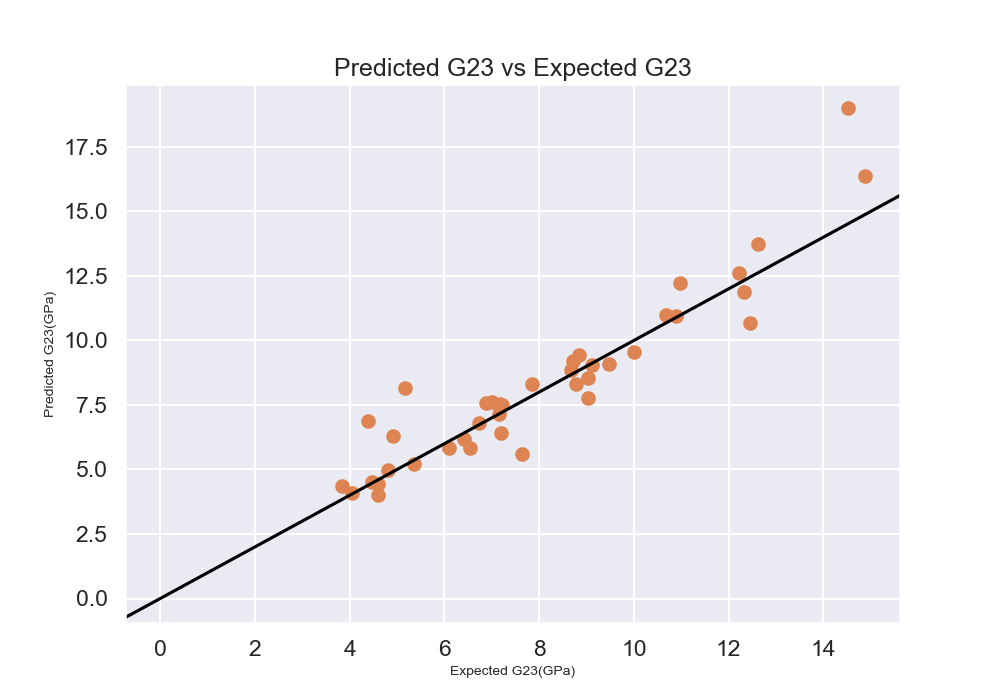

In [43]:
evaluation_plot(ytest, test_ypred, scaler, targets,parameters)

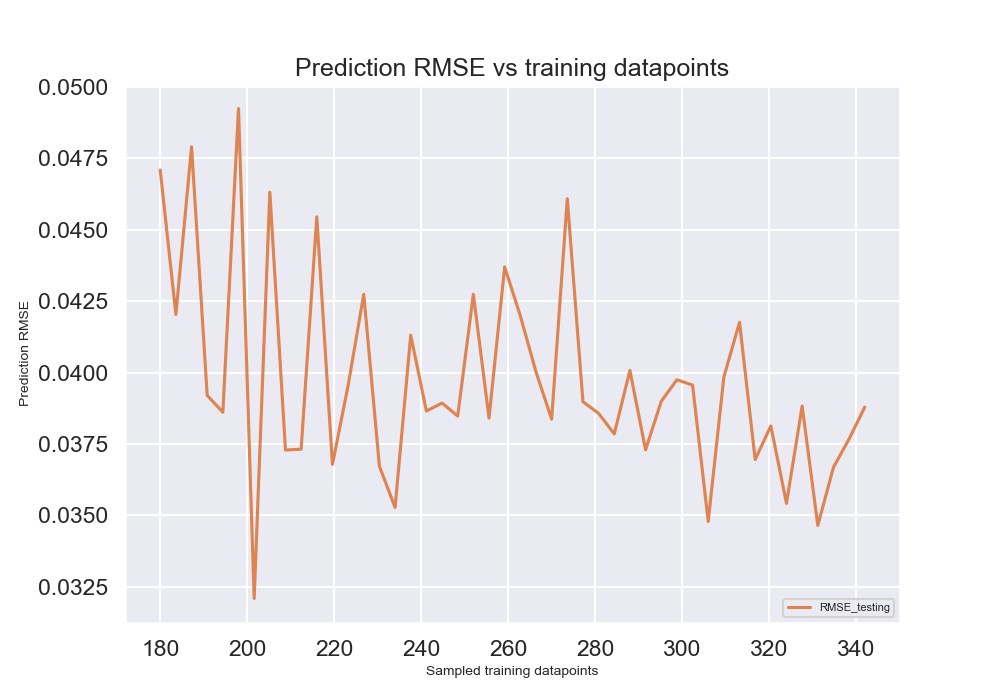

In [50]:
model_RMSE(training_data, test_RMSE_array)

In [151]:
pd.DataFrame(ytest, columns = targets)

,E11,E22,E33,nu12,nu13,nu23,G12,G13,G23
130,165256.7,14359.00,15111.00,0.326390,0.317360,0.480567,4490.333,4781.333,4352.000
227,148023.3,12575.00,12125.67,0.288467,0.287293,0.335533,5200.000,4991.333,4529.667
275,310156.7,19846.67,19019.67,0.264650,0.269847,0.435133,7323.333,7038.667,7173.333
192,123443.3,28264.33,27222.33,0.376100,0.378933,0.529933,8666.667,8138.000,10180.000
204,324010.0,33843.33,32999.00,0.289307,0.291983,0.448600,11730.330,11340.670,12080.670
...,...,...,...,...,...,...,...,...,...
297,202786.7,22502.67,23734.00,0.264510,0.262087,0.322457,9053.333,9600.667,7982.667
294,352833.3,20336.00,19257.33,0.302183,0.308797,0.507600,6637.000,6144.667,7516.333
357,84050.0,21688.33,21437.33,0.326797,0.327760,0.434267,7555.667,7479.333,7493.333
153,190196.7,25436.67,25078.33,0.293253,0.293523,0.354500,10074.670,9957.000,9295.333


In [155]:
#dataframe_to_latex( pd.DataFrame(ytest, columns = targets) )

In [156]:
#pd.DataFrame(test_ypred, columns = targets)

In [157]:
#dataframe_to_latex( pd.DataFrame(test_ypred, columns = targets) )

In [158]:
pd.DataFrame(scaler.inverse_transform(test_ypred), columns = targets)

,E11,E22,E33,nu12,nu13,nu23,G12,G13,G23
0,173395.251743,15128.367143,14840.240946,0.320676,0.325642,0.518552,4568.456945,4342.140352,4462.470609
1,152163.535312,12498.995935,12188.315402,0.287564,0.290005,0.331496,5453.283700,5307.328934,4460.537593
2,293817.090729,18507.068089,18784.290050,0.269667,0.272979,0.429397,6850.884520,6750.874781,6804.512905
3,122359.401787,27435.844173,27143.461052,0.380110,0.380727,0.524669,8010.153914,7739.426919,9001.607465
4,323944.226709,33677.759680,32920.200306,0.290419,0.294009,0.470036,11737.761444,11145.401349,12131.630151
...,...,...,...,...,...,...,...,...,...
35,231881.273041,22379.546361,22982.326214,0.259503,0.244807,0.258798,9482.488410,10148.645852,9048.096322
36,364934.117383,22220.325893,21530.660781,0.311793,0.309025,0.508647,6274.537509,6346.557157,7618.387764
37,84353.242145,22217.071030,22377.345042,0.326587,0.329414,0.431128,7528.957053,7675.142551,7801.712592
38,191616.681696,23468.578899,23366.827755,0.294699,0.296643,0.379665,9451.407509,9326.970687,8791.416418


In [159]:
dataframe_to_latex( pd.DataFrame(scaler.inverse_transform(test_ypred), columns = targets) )

\begin{tabular}{rrrrrrrrr}
\toprule
     E11 &     E22 &     E33 &  nu12 &  nu13 &  nu23 &     G12 &     G13 &     G23 \\
\midrule
173395.3 & 15128.4 & 14840.2 &   0.3 &   0.3 &   0.5 &  4568.5 &  4342.1 &  4462.5 \\
152163.5 & 12499.0 & 12188.3 &   0.3 &   0.3 &   0.3 &  5453.3 &  5307.3 &  4460.5 \\
293817.1 & 18507.1 & 18784.3 &   0.3 &   0.3 &   0.4 &  6850.9 &  6750.9 &  6804.5 \\
122359.4 & 27435.8 & 27143.5 &   0.4 &   0.4 &   0.5 &  8010.2 &  7739.4 &  9001.6 \\
323944.2 & 33677.8 & 32920.2 &   0.3 &   0.3 &   0.5 & 11737.8 & 11145.4 & 12131.6 \\
\bottomrule
\end{tabular}



/var/folders/cb/vrjht0fx48d3g_xc6hc9qphw0000gn/T/ipykernel_61397/1490068444.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(( dataframe.head(5) ).to_latex(index=False, formatters={"name": str.upper},float_format="{:.1f}".format,))


In [ ]:
pd.DataFrame( data=test_rmse_arr, columns = targets ).iloc[1:]

In [ ]:
pd.DataFrame( data=unscaled_test_rmse_arr, columns = targets ).iloc[1:]

In [ ]:
test_data[targets]

In [ ]:

plt.close()
plt.figure(figsize=(7,7))
plt.title( "Test RMSE vs training datapoints")
plt.plot( [ len(training_data)*0.01*i for i in range(50,96,1) ] ,test_RMSE_array, label = "RMSE_testing", color='C1')
plt.xlabel('Training datapoints',fontsize=10)
plt.ylabel('Test data RMSE',fontsize=10)
plt.legend(loc=4,prop={'size': 8})
#plt.legend(["First data with {}".format(input_var1),"Second data with {}".format(input_var2)])
plt.savefig('RMSE_testing_400_MinMaxScaler.png',bbox_inches='tight')
plt.show()


In [ ]:
ytest

In [ ]:
prediction = scaler.inverse_transform(test_ypred)
prediction_df = pd.DataFrame(prediction, columns=output_features)
prediction_df

In [ ]:
#plt.close()
#plt.figure(figsize=(7,7))
#plt.title("RMSE validation vs training datapoints")
#plt.plot( [ len(model_data)*0.01*i for i in range(20,80,1) ] ,RMSE_validation_array, label = "RMSE_validation", color='C1')
##plt.plot( [ len(model_data)*0.01*i for i in range(20,90,1) ] ,RMSE_training_array[::-1], label = "RMSE_training")
#plt.xlabel('Datapoints',fontsize=10)
#plt.ylabel('Validation RMSE',fontsize=10)
#plt.legend(loc=4,prop={'size': 8})
#plt.savefig('RMSE_validation_400.png',bbox_inches='tight')
#plt.show()

#RMSE_validation_array

In [ ]:
test_ypred_df = pd.DataFrame(data=test_ypred, columns = ['E11','E22','nu12','nu13','nu23','G12','G13','G23'])
test_output_df = pd.DataFrame(data=test_output, columns = ['E11','E22','nu12','nu13','nu23','G12','G13','G23'])
plt.figure(figsize=(15.8,6))
plt.scatter(range(len(test_input)),test_output_df['E11'],label = "test E11", marker="o", color='b')
plt.scatter(range(len(test_ypred)),test_ypred_df['E11'],label = "predicted E11", marker="o", color='r')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('E11', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

### Comparing our ground truth and predicted values

In [ ]:
plt.figure(figsize=(15.8,5))
plt.plot(range(len(y_test_df)), y_test_df['nu12'], 'o', label = "Normalized ytest E11")
plt.plot(range(len(pred_output)), pred_output['nu12'], '*', label = "Normalized ypred E11", color='C1')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Outputs', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
#plt.fill_between(range(len(y_test_df)),
#               [i - mse for i in pred_output['E11'] ],
#               [i + mse for i in pred_output['E11'] ],
#               facecolor='red')
plt.show()

### Performing an error analysis

In [ ]:
MSE_analysis(ytest, y_pred)[1]

### Bias evaluation

We need to evaluate the error convergence for different portions of the dataset. We consider a percentage of the dataset, of which we use for training of the model. Upon training our model, we use it to analyse the error from ground truth values of the other portion of the dataset and the predicted values.
We need to be mindful of using the appropriate error measure consistently across all evaluations.

In [ ]:
df

## Gaussian processes for a time dependent sequential process

### Processing

#### Unpack data

In [ ]:
x_train_mean = stack( meanfield['X_train'] )
y_train_mean = stack( meanfield['Y_train'] )
x_test_mean = stack( meanfield['X_test'] )
y_test_mean = stack( meanfield['Y_test'] )

x_train_global = stack( meanfield_glob_scaled['X_train'] )
y_train_global = stack( meanfield_glob_scaled['Y_train'] )
x_test_global = stack( meanfield_glob_scaled['X_test'] )
y_test_global = stack( meanfield_glob_scaled['Y_test'] )

In [ ]:
y_test_mean.shape

In [ ]:
y_test_mean.ndim

#### Define parameters

In [ ]:
#features = Time_increment,E11,E22,E33,E12,E13,E23,Fibre_Young_modulus,Fibre_Poisson_ratio,Matrix_Young_modulus,Matrix_poisson_ratio,Matrix_yield_stress,Matrix_hardening_modulus,Matrix_hardening_exponent,Matrix_2nd_hardening_modulus,Fibre_volume_fraction
mean_labels = ['Time increment','E11','E22','E33','E12','E13','E23','Fibre young modulus','Fibre poisson ratio','Matrix young modulus','Matrix poisson ratio','Matrix yield stress','Matrix hardening modulus','Matrix hardening exponent','Matrix 2nd hardening modulus','Fibre volume fraction']
global_labels = ['E11','E22','E33','E12','E13','E23','Fibre young modulus','Fibre poisson ratio','Matrix young modulus','Matrix poisson ratio','Matrix yield stress','Matrix hardening modulus','Matrix hardening exponent','Matrix 2nd hardening modulus','Fibre volume fraction']
y_labels = ['ε11','ε22','ε33','ε12','ε13','ε23']

#### Use Pandas to display sample data

In [ ]:
df_x_test_mean = pd.DataFrame(x_test_mean.transpose(), columns=mean_labels)
df_y_test_mean = pd.DataFrame( y_test_mean.transpose() )
df_x_train_mean = pd.DataFrame(x_train_mean.transpose(), columns=mean_labels)
df_y_test_mean = pd.DataFrame( y_train_mean.transpose() )


df_x_test_global = pd.DataFrame(x_test_global.transpose(), columns=global_labels)
df_y_test_global = pd.DataFrame( y_test_global.transpose(), columns=y_labels )
df_x_train_global = pd.DataFrame(x_train_global.transpose(), columns=global_labels)
df_y_train_global = pd.DataFrame( y_train_global.transpose(), columns=y_labels )

In [ ]:
df_x_train_global

In [ ]:
df_y_train_global

#### Plot data

We will go ahead and try to plot one type of sequential loading from the data; E11, as well as the respective stress response ε11.

In [ ]:
plt.figure(figsize=(15.5,5))
ax = sns.lineplot(df_x_train_global, x= range(len(df_x_train_global)), y=df_x_train_global['E11'])
ax.set(xlabel='Time steps', ylabel='E11')
ax.set(title='E11 sequential loading (strain)')

In [ ]:
plt.figure(figsize=(15.5,5))
ax = sns.lineplot(df_y_train_global, x= range(len(df_y_train_global)), y=df_y_train_global['ε11'])
ax.set(xlabel='Time steps', ylabel='$\sigma$11')
ax.set(title='$\sigma$11 stress response')

In the following we will perform Gaussian Process regression of the parameters vs. the response for a simulated set of 2000 time intervals

In [ ]:
#Raw training data
x_tr_g = ( df_x_train_global[['E11','E22','E33','E12','E13','E23']] ).to_numpy()
y_tr_g = y_train_global.transpose()
#y_tr_g = y_train_global

#Normalized testing values
x_te_g = ( df_x_test_global[['E11','E22','E33','E12','E13','E23']] ).to_numpy()
y_te_g = y_test_global.transpose()
#y_te_g = y_test_global

print(x_tr_g.shape)
print(y_tr_g.shape)


In [ ]:
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * Matern(length_scale=0.8, length_scale_bounds=(1e-05, 100000.0), nu=1.5)
#kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(length_scale=0.8, length_scale_bounds="fixed")
#print(f'Initial kernel: \n{k}')
#L = np.linalg.cholesky(k)
#gp.L_ = L
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(x_tr_g, y_tr_g)
y_mean_pred, std_prediction = gpr.predict(x_te_g,return_std=True)
mse = mean_squared_error(y_te_g, y_mean_pred)
print("Mean Squared Error:", mse)
score = gpr.score(x_tr_g, y_tr_g)
print("R Squared score:", score)

In [ ]:
df_y_pred = pd.DataFrame(y_mean_pred, columns=y_labels )
df_y_pred

In [ ]:
df_y_test_global

In [ ]:
plt.figure(figsize=(15.5,5))
plt.plot(range(len(df_y_train_global)),df_y_test_global['ε11'],label = "Test values")
plt.plot(range(len(df_y_train_global)),df_y_pred['ε11'],label = "Predicted values")
plt.xlabel('Samples at time steps', fontsize=10)
plt.ylabel('Strain response', fontsize=10)
plt.legend(loc=4, prop={'size': 8})
plt.show()

In [ ]:
#def kernel(x1, x2, gamma=5):
#    rbf = lambda x, y: np.exp(
#        - gamma * np.linalg.norm([x - y], 2)**2
#    )
#    K = np.empty((len(x1), len(x2))) + WhiteKernel(noise_level=3e-8)
#    for i, a in enumerate(x1):
#        for j, b in enumerate(x2):
#            K[i, j] = rbf(a, b)
#    return K


def seq_gpr(xtrain, ytrain, xtest):
    x_updated = np.empty((xtrain.shape[0],xtrain.shape[1]))
    y_updated = np.array([])
    
    # Loop through each new observation
    for i in range(len(xtrain)):
        # Obtain the new observation
        x_new = xtrain[i]
        y_new = ytrain[i]
        
        # Reshape the input to be a 2D array
        #x_new = x_new.reshape(1, -1)
        
        # Add the new observation to the updated data and targets
        #x_updated = np.vstack((x_updated, x_new))
        #y_updated = np.append(y_updated, y_new)
        
        # Compute the kernel matrix for the updated data
        
        kernel = Matern()
        K_ss = kernel(xtest[i],xtest[i])
        
        #K = kernel(x_updated,x_updated) + WhiteKernel(noise_level=3e-7)
        #kernel = SquaredExponentialKernel()
        #K_ss = kernel(x_updated, x_updated)
        #L_ss = np.linalg.cholesky(K_ss)
        
        K = kernel(x_updated, x_updated)
        L = np.linalg.cholesky(K)
        m = np.linalg.solve(L, y_updated)
        alpha = np.linalg.solve(L.T, m)
        
        K_s = kernel(xtrain, xtest)
        mu = K_s.T @ alpha
        
        beta = np.linalg.solve(K, K_s)
        cov = K_ss - K_s.T @ beta
        
        L_cov = np.linalg.cholesky(cov)
        
        gp.L_ = L_cov
        
        # Update the Cholesky decomposition of the kernel matrix
        #gp.L_ = np.linalg.cholesky( K )
        
    # Fit the Gaussian process with the final covariance matrix
    gp = GaussianProcessRegressor()
    gp.fit(x_updated, y_updated)
    
    # Make a prediction using the final fit
    x_pred = xtest  # Input features for prediction
    y_pred_mean, y_pred_std = gp.predict(x_pred, return_std=True)
    mse = mean_squared_error(y_te_g, y_mean_pred)
    score = model.score(y_te_g, y_mean_pred)
    return(f'Mean Squared Error:{mse}', f'R Squared score:{score}')

seq_gpr(x_tr_g, y_tr_g,x_te_g)

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2